In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model

from hysteresis.base import BaseHysteresis
from hysteresis.trainable_hybrid import ExactHybridGP
from hysteresis.visualization import plot_hysterion_density

def load():
    aps_model = torch.load('aps_model.pt')

    train_h = aps_model.history_h.reshape(-1, 1)
    train_m = aps_model.history_m.reshape(-1, 1)

    train_y = torch.sin(train_m * 2 * 3.14 / 40)
    return train_h, train_m, train_y

In [2]:
train_x, train_m, train_y = load()
H = BaseHysteresis(train_x.flatten(), polynomial_degree=3)
for constraint_name, constraint in H.named_constraints():
    print(f'Constraint name: {constraint_name:55} constraint = {constraint}')
likelihood = GaussianLikelihood()
model = ExactHybridGP(train_x, train_y.flatten(), H, likelihood)

mll = ExactMarginalLogLikelihood(likelihood, model)
fit_gpytorch_model(mll)
print(list(model.named_parameters()))

Constraint name: raw_hysterion_density_constraint                        constraint = Interval(0.000E+00, 1.000E+00)
Constraint name: raw_offset_constraint                                   constraint = Interval(-1.000E+01, 1.000E+01)
Constraint name: raw_scale_constraint                                    constraint = Interval(0.000E+00, 2.000E+01)
Constraint name: raw_slope_constraint                                    constraint = Interval(-2.000E+01, 2.000E+01)
[('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([-49.8850], requires_grad=True)), ('hysteresis_models.0.raw_hysterion_density', Parameter containing:
tensor([  7.4368,   7.9078, -12.2422,   7.2161,   9.7168,   8.6355,   5.2339,
        -17.1976,  -8.9006,  -7.1839,  -8.0778, -15.5097, -17.7390, -18.7023,
        -20.3823, -17.5720,  16.8097,  15.3950,  19.5702,  20.5127,  14.3674,
         12.2507,   8.1024,  -4.3164, -13.2526, -16.0433, -18.8725, -13.9185,
         -0.0786,  14.8826,   9.3573,   7.9078,  

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

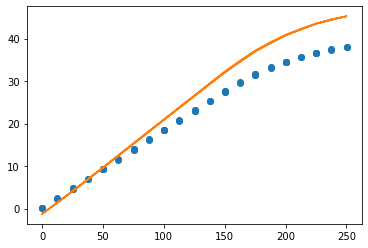

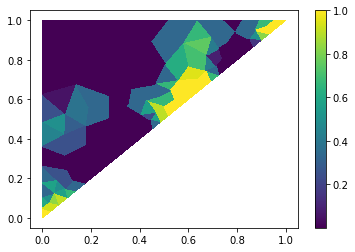

In [3]:
# prediction of hysteresis
model.hysteresis_models[0].regression()
plt.figure()
plt.plot(train_x, train_m, 'o')
plt.plot(
    train_x,
    model.hysteresis_models[0](train_x.flatten(), return_real=True).detach()
)

plot_hysterion_density(model.hysteresis_models[0])

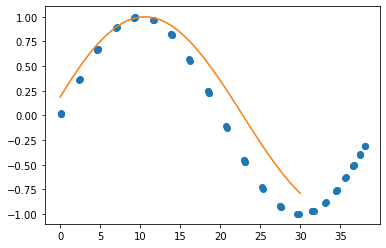

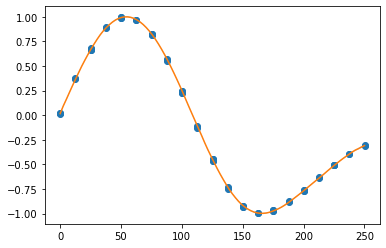

In [4]:
model_copy = deepcopy(model)
if 1:
    # predict from magnetization
    model.eval()
    train_m_test = torch.linspace(0, 30, 100).double()
    with torch.no_grad():
        postm = model_copy(train_m_test, from_magnetization=True)
        meanm = postm.mean
        lm, um = postm.confidence_region()

    plt.figure()
    plt.plot(train_m, train_y, 'o')
    plt.plot(train_m_test, meanm.detach())
    plt.fill_between(train_m_test, lm, um, alpha=0.25)

# predict with joint model
test_x = torch.linspace(*H.valid_domain, 100)
with torch.no_grad():
    post = model(test_x.double())
    mean = post.mean
    l, u = post.confidence_region()

plt.figure()
plt.plot(train_x, train_y, 'o')
plt.plot(test_x, mean)
plt.fill_between(test_x, l, u, alpha=0.25)

plt.show()